In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


objc[1649]: Class CaptureDelegate is implemented in both /usr/local/Cellar/opencv/4.11.0_1/lib/libopencv_videoio.4.11.0.dylib (0x10ee76858) and /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cv2/cv2.abi3.so (0x2c29e26d0). One of the two will be used. Which one is undefined.
objc[1649]: Class CVWindow is implemented in both /usr/local/Cellar/opencv/4.11.0_1/lib/libopencv_highgui.4.11.0.dylib (0x10876cb70) and /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cv2/cv2.abi3.so (0x2c29e2720). One of the two will be used. Which one is undefined.
objc[1649]: Class CVView is implemented in both /usr/local/Cellar/opencv/4.11.0_1/lib/libopencv_highgui.4.11.0.dylib (0x10876cb98) and /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cv2/cv2.abi3.so (0x2c29e2748). One of the two will be used. Which one is undefined.
objc[1649]: Class CVSlider is implemented in both /usr/local/Cellar/opencv/4.11.0_1/lib/libo

In [ ]:
# All in RGB
all_valid_colors = [
    [0, 0, 0],
	[255, 255, 255],
	[231, 120, 23],
	[0, 147, 221],
	[245, 240, 20],
	[75, 176, 51],
	[218, 37, 29],
]

In [3]:
# Convert all valid colors into their HSV and print them


all_valid_HSV = []

# skip black and white
for color in all_valid_colors[2:]:
	color = np.array(color, dtype=np.uint8)
	hsv_color = cv2.cvtColor(color.reshape(1, 1, 3), cv2.COLOR_RGB2HSV)[0][0]
	print(f'RGB: {color}, HSV: {hsv_color}')
	all_valid_HSV.append(hsv_color)



RGB: [231 120  23], HSV: [ 14 230 231]
RGB: [  0 147 221], HSV: [100 255 221]
RGB: [245 240  20], HSV: [ 29 234 245]
RGB: [ 75 176  51], HSV: [ 54 181 176]
RGB: [218  37  29], HSV: [  1 221 218]


In [ ]:
full_img = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00006.jpeg"
full_img = np.array(cv2.imread(full_img, cv2.IMREAD_COLOR))
full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2HSV).astype(np.float32) / 255.0

reference_HSV = np.array(all_valid_HSV).astype(np.float32) / 255.0

def get_hue_masks(full_img, reference_HSV, weights = [1.0,0.0,0.0], threshold=0.5, sigma=0.05, sat_min=0.2, val_min=0.2):
	'''
	Gets an image loaded in HSV format and an array of reference HSV colors
	Both are normalized to 1.0 max np.float32 values
	Returns an array of masks, one for each reference HSV color, with white pixels in regions matching
	to a certain degree the corresponding refenence HSV color.
	
	reference_HSV is not supposed to contain black or white, handled by setting minimum values for both saturation (S) and value (V)
	'''
	h, w, _ = full_img.shape
	pixels_hsv = full_img.reshape(-1, 3)  # (num_pixels, 3)

	# Compute circular hue distance
	h_diff = np.abs(pixels_hsv[:, None, 0] - reference_HSV[None, :, 0])
	h_dist = np.minimum(h_diff, 1.0 - h_diff)

	# Mask out low-S or low-V pixels
	low_sv_mask = (pixels_hsv[:,1] < sat_min) | (pixels_hsv[:,2] < val_min)
	h_dist[low_sv_mask, :] = np.inf

	s_dist = np.abs(pixels_hsv[:, None, 1] - reference_HSV[None, :, 1]) if weights[1] > 0 else np.zeros_like(h_dist)
	v_dist = np.abs(pixels_hsv[:, None, 2] - reference_HSV[None, :, 2]) if weights[2] > 0 else np.zeros_like(h_dist)

	w_h, w_s, w_v = weights
	dists = np.sqrt(
		w_h * h_dist**2 
		+ w_s * s_dist**2
		+ w_v * v_dist**2
				 )

	# Soft assignment using Gaussian kernel
	weights_soft = np.exp(- (dists**2) / (2 * sigma**2))  # shape (num_pixels, num_colors)

	# For masked out pixels (inf), set weights to 0
	weights_soft[np.isinf(dists)] = 0

	# Reshape back to (h, w, num_colors)
	weights_img = weights_soft.reshape(h, w, -1)

	# # Plot masks using simple threshold
	# fig, axs = plt.subplots(1, len(reference_HSV), figsize=(22, 4))
	# fig.suptitle("HSV Soft Gaussian weights masks for image test")

	results_hsv = []
	for i in range(len(reference_HSV)):
		channel = weights_img[:, :, i]
		binary_mask = (channel > threshold).astype(np.uint8)
		results_hsv.append(binary_mask * 255)

		# axs[i].imshow(binary_mask, cmap='gray')
		# axs[i].set_title(f"HSV Color {i}")
		# axs[i].axis('off')

	# plt.show()
	return results_hsv

In [7]:
results_hsv = get_hue_masks(full_img, reference_HSV)

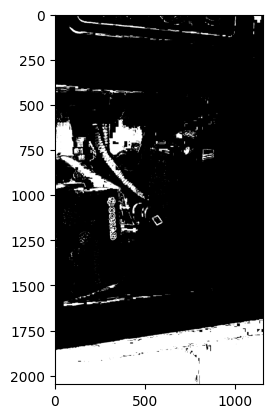

In [8]:
plt.imshow(results_hsv[-1],cmap="gray")